In [1]:
import pandas as pd
import os
import sys
import numpy as np

In [ ]:
# Define paths to saved feature files
MSHDS_FEATURES_PATH = '../data/Processed_Features/features_mshds_reading_task.csv'
OPENSMILE_FEATURES_PATH = '../data/Processed_Features/features_opensmile_reading_task.csv'
WAV2VEC2_FEATURES_PATH = '../data/Processed_Features/features_wav2vec2_reading_task.csv'

# Dictionary to hold loaded data for easy access
datasets = {}
feature_sets = {}

In [3]:
# Load MSHDS Features
try:
    datasets['mshds'] = pd.read_csv(MSHDS_FEATURES_PATH)
    print(f"Successfully loaded MSHDS features. Shape: {datasets['mshds'].shape}")
except FileNotFoundError:
    print(f"ERROR: MSHDS feature file not found at {MSHDS_FEATURES_PATH}")

Successfully loaded MSHDS features. Shape: (111, 35)


In [4]:
# Load OpenSMILE Features
try:
    datasets['opensmile'] = pd.read_csv(OPENSMILE_FEATURES_PATH)
    print(f"Successfully loaded OpenSMILE features. Shape: {datasets['opensmile'].shape}")
except FileNotFoundError:
    print(f"ERROR: OpenSMILE feature file not found at {OPENSMILE_FEATURES_PATH}")

Successfully loaded OpenSMILE features. Shape: (111, 921)


In [5]:
# Load Wav2Vec2 Features
try:
    datasets['wav2vec2'] = pd.read_csv(WAV2VEC2_FEATURES_PATH)
    print(f"Successfully loaded Wav2Vec2 features. Shape: {datasets['wav2vec2'].shape}")
except FileNotFoundError:
    print(f"ERROR: Wav2Vec2 feature file not found at {WAV2VEC2_FEATURES_PATH}")

Successfully loaded Wav2Vec2 features. Shape: (111, 778)


In [ ]:
# Prepare Feature Sets (X) and Labels (y)

# Define which columns are metadata and should not be used as features
# Use the MSHDS dataset to define metadata assuming they are the same across all files.
if 'mshds' in datasets:
    metadata_cols = [
        'unique_participant_id', 'original_id_nn', 'label', 'gender', 'age', 
        'education', 'filepath', 'filename', 'task_type', 'fold'
    ]
    # For Wav2Vec2, 'duration_sec' might also be present and should be excluded
    # Handle by checking for column existence.
    
    for name, df in datasets.items():
        print(f"\nProcessing feature set: {name}")
        
        # Define the label vector (y). Convert 'Patient'/'Control' to 1/0
        y = df['label'].apply(lambda x: 1 if x == 'Patient' else 0)
        
        # Define the feature matrix (X) by dropping metadata columns
        # Find which metadata columns actually exist in this specific dataframe
        cols_to_drop = [col for col in metadata_cols if col in df.columns]
        
        X = df.drop(columns=cols_to_drop)
        
        # Also drop any other non-feature columns that might exist
        if 'File' in X.columns: # from MSHDS extractor
             X = X.drop(columns=['File'])
        if 'duration_sec' in X.columns: # from Wav2Vec2 extractor
             X = X.drop(columns=['duration_sec'])

        # Store the prepared X and y in our new dictionary
        feature_sets[name] = {'X': X, 'y': y, 'groups': df['unique_participant_id']}
        
        print(f"  - Prepared X with shape: {X.shape}")
        print(f"  - Prepared y with shape: {y.shape}")
else:
    print("Could not find the base 'mshds' dataset to define metadata columns.")

# Can now access the data for any feature set, e.g.:
# X_mshds = feature_sets['mshds']['X']
# y_mshds = feature_sets['mshds']['y']


Processing feature set: mshds
  - Prepared X with shape: (111, 25)
  - Prepared y with shape: (111,)

Processing feature set: opensmile
  - Prepared X with shape: (111, 911)
  - Prepared y with shape: (111,)

Processing feature set: wav2vec2
  - Prepared X with shape: (111, 768)
  - Prepared y with shape: (111,)


In [ ]:
import pandas as pd
import os
import sys
import numpy as np
from collections import Counter
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc

# Setup Paths and Load Modules

# Add 'src' directory to the Python path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import custom functions, kfold and nested kfold for SVM
from src.cv_strategies import run_standard_kfold_cv, run_nested_kfold_cv

# Set some plotting styles for graphs
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 7)

In [ ]:
# Load All Processed Feature Sets

# Define paths to saved feature files
MSHDS_FEATURES_PATH = '../data/Processed_Features/features_mshds_reading_task.csv'
OPENSMILE_FEATURES_PATH = '../data/Processed_Features/features_opensmile_reading_task.csv'
WAV2VEC2_FEATURES_PATH = '../data/Processed_Features/features_wav2vec2_reading_task.csv'

# Dictionary to hold loaded data for easy access
datasets = {}
feature_sets = {}

# Load all three feature sets
try:
    datasets['mshds'] = pd.read_csv(MSHDS_FEATURES_PATH)
    datasets['opensmile'] = pd.read_csv(OPENSMILE_FEATURES_PATH)
    datasets['wav2vec2'] = pd.read_csv(WAV2VEC2_FEATURES_PATH)
    print("All feature sets loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: A feature file was not found. Please ensure all feature extraction steps are complete.\n - {e}")

# Prepare Feature Sets (X) and Labels (y)
print("\n--- Preparing Feature Sets (X) and Labels (y) ---")
if datasets:
    metadata_cols = [
        'unique_participant_id', 'original_id_nn', 'label', 'gender', 'age', 
        'education', 'filepath', 'filename', 'task_type', 'fold'
    ]
    
    for name, df in datasets.items():
        # Define the label vector (y)
        y = df['label'].apply(lambda x: 1 if x == 'Patient' else 0)
        
        # Define the feature matrix (X) by dropping metadata and other non-feature columns
        cols_to_drop = [col for col in metadata_cols if col in df.columns]
        X = df.drop(columns=cols_to_drop)
        extra_cols_to_drop = ['File', 'duration_sec']
        X = X.drop(columns=[col for col in extra_cols_to_drop if col in X.columns], errors='ignore')
        
        # Handle potential NaN values in features by filling with the column mean
        X = X.fillna(X.mean())

        feature_sets[name] = {'X': X, 'y': y, 'groups': df['unique_participant_id']}
        print(f"Prepared '{name}' feature set with X shape: {X.shape}")
else:
    print("Could not find any datasets to process.")

# Can access the data for any feature set, e.g.:
# X_mshds = feature_sets['mshds']['X']
# y_mshds = feature_sets['mshds']['y']

All feature sets loaded successfully.

--- Preparing Feature Sets (X) and Labels (y) ---
Prepared 'mshds' feature set with X shape: (111, 25)
Prepared 'opensmile' feature set with X shape: (111, 911)
Prepared 'wav2vec2' feature set with X shape: (111, 768)


In [ ]:
# Run All Experiments 

# Dictionary to store all our results
all_results = {}

# Test a fixed number of features for the standard k-fold.
# Start with is 25, similar to the MSHDS feature set size.
N_FEATURES_TO_SELECT_STANDARD = 25

for name, data in feature_sets.items():
    print(f"\n--- Running experiments for feature set: {name.upper()} ---")
    X, y = data['X'], data['y']
    
    # Run Standard K-fold CV
    print(f"Running Standard K-fold with k={N_FEATURES_TO_SELECT_STANDARD}...")
    std_results_df, std_preds = run_standard_kfold_cv(X, y, n_features_to_select=N_FEATURES_TO_SELECT_STANDARD)
    all_results[f'{name}_standard'] = {'results_df': std_results_df, 'predictions': std_preds}
    
    # Run Nested K-fold CV
    print("Running Nested K-fold...")
    nested_results_df, nested_preds = run_nested_kfold_cv(X, y)
    all_results[f'{name}_nested'] = {'results_df': nested_results_df, 'predictions': nested_preds}

print("\n--- All experiments complete! ---")


--- Running experiments for feature set: MSHDS ---
Running Standard K-fold with k=25...


Standard K-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Running Nested K-fold...


Nested K-fold:   0%|          | 0/5 [00:00<?, ?it/s]


--- Running experiments for feature set: OPENSMILE ---
Running Standard K-fold with k=25...


Standard K-fold:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\ayush\miniconda3\envs\msc_speech_framework\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [171 411 420 423 435 495 602 603 610] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ayush\miniconda3\envs\msc_speech_framework\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ayush\miniconda3\envs\msc_speech_framework\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [171 411 420 423 435 495 602 603 610] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ayush\miniconda3\envs\msc_speech_framework\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ayush\miniconda3\envs\msc_speech_framew

Running Nested K-fold...


c:\Users\ayush\miniconda3\envs\msc_speech_framework\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [171 411 420 423 435 446 495 602 603 610] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ayush\miniconda3\envs\msc_speech_framework\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ayush\miniconda3\envs\msc_speech_framework\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [168 171 363 408 411 420 423 432 435 444 447 483 495 507 519 602 603 610] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ayush\miniconda3\envs\msc_speech_framework\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Nested K-fold:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\ayush\miniconda3\envs\msc_speech_framework\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [171 298 411 420 423 435 446 495 602 603 610] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ayush\miniconda3\envs\msc_speech_framework\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ayush\miniconda3\envs\msc_speech_framework\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [171 358 411 420 423 435 495 602 603 610] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ayush\miniconda3\envs\msc_speech_framework\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ayush\miniconda3\envs\msc_s


--- Running experiments for feature set: WAV2VEC2 ---
Running Standard K-fold with k=25...


c:\Users\ayush\miniconda3\envs\msc_speech_framework\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [168 171 363 408 411 420 423 432 435 444 447 483 495 507 519 602 603 610] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ayush\miniconda3\envs\msc_speech_framework\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Standard K-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Running Nested K-fold...


Nested K-fold:   0%|          | 0/5 [00:00<?, ?it/s]


--- All experiments complete! ---


In [ ]:
# Consolidate and Display Final Results Table

summary_data = []
for experiment_name, data in all_results.items():
    results_df = data['results_df']
    summary_data.append({
        'Experiment': experiment_name,
        'Mean Accuracy': results_df['accuracy'].mean(),
        'Std Dev Accuracy': results_df['accuracy'].std(),
        'Mean Precision': results_df['precision'].mean(),
        'Std Dev Precision': results_df['precision'].std(),
        'Mean Recall': results_df['recall'].mean(),
        'Std Dev Recall': results_df['recall'].std(),
        'Mean F1-Score': results_df['f1_score'].mean(),
        'Std Dev F1-Score': results_df['f1_score'].std(),
        'Mean AUC': results_df['auc'].mean(),
        'Std Dev AUC': results_df['auc'].std(),
    })

summary_df = pd.DataFrame(summary_data).set_index('Experiment')

# Display the summary table with nice formatting
display(summary_df.style.background_gradient(cmap='viridis', axis=0)
                      .set_caption("Performance Metrics Summary Across All Experiments")
                      .format("{:.3f}"))

,Mean Accuracy,Std Dev Accuracy,Mean Precision,Std Dev Precision,Mean Recall,Std Dev Recall,Mean F1-Score,Std Dev F1-Score,Mean AUC,Std Dev AUC
Experiment,,,,,,,,,,
mshds_standard,0.738,0.076,0.742,0.075,0.736,0.080,0.735,0.081,0.810,0.068
mshds_nested,0.711,0.176,0.719,0.178,0.708,0.176,0.706,0.176,0.764,0.181
opensmile_standard,0.594,0.100,0.595,0.109,0.590,0.103,0.586,0.104,0.572,0.096
opensmile_nested,0.566,0.093,0.567,0.095,0.565,0.094,0.563,0.094,0.565,0.105
wav2vec2_standard,0.666,0.070,0.673,0.068,0.669,0.069,0.664,0.071,0.703,0.096
wav2vec2_nested,0.658,0.039,0.670,0.052,0.660,0.038,0.654,0.036,0.766,0.090


C:\Users\ayush\AppData\Local\Temp\ipykernel_22072\2734102815.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x='Experiment', y='Mean F1-Score', ax=ax[0], palette='viridis')
C:\Users\ayush\AppData\Local\Temp\ipykernel_22072\2734102815.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha="right")
C:\Users\ayush\AppData\Local\Temp\ipykernel_22072\2734102815.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x='Experiment', y='Mean AUC', ax=ax[1], palette='plasma')
C:\Users\ayush\AppData\Local\Temp\ipykernel_22072\2

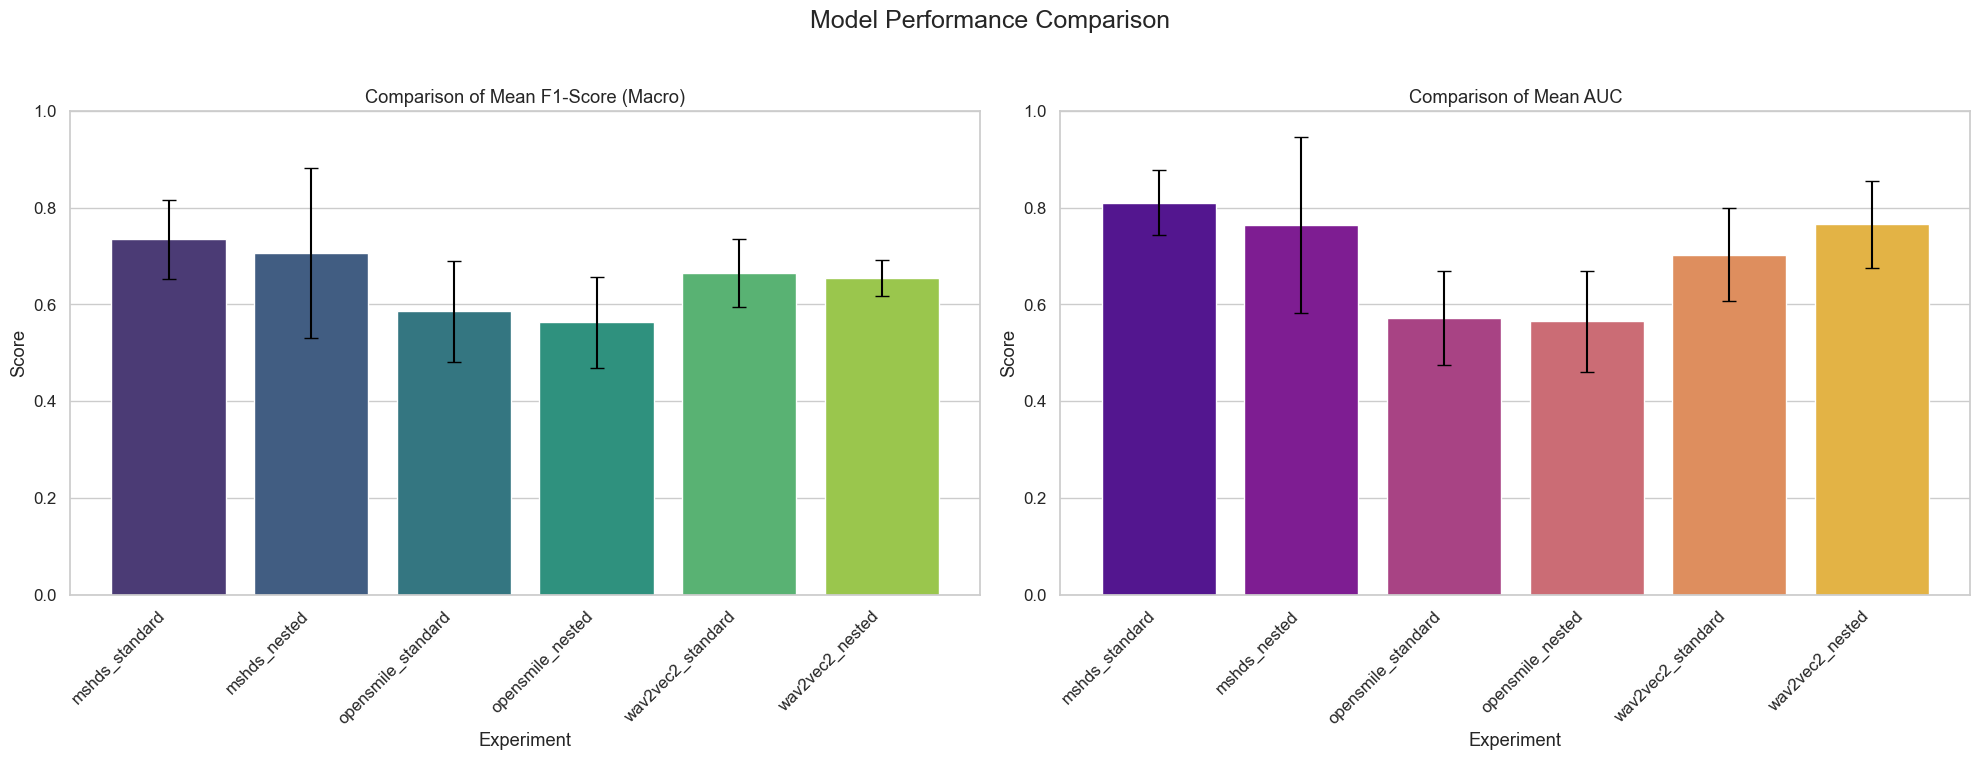

In [ ]:
# Visualize Mean Performance Metrics

# Prepare data for plotting
plot_df = summary_df[['Mean F1-Score', 'Mean AUC']].reset_index()

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Plot for F1-Score
sns.barplot(data=plot_df, x='Experiment', y='Mean F1-Score', ax=ax[0], palette='viridis')
ax[0].errorbar(x=plot_df.index, y=summary_df['Mean F1-Score'], 
               yerr=summary_df['Std Dev F1-Score'], fmt='none', c='black', capsize=5)
ax[0].set_title('Comparison of Mean F1-Score (Macro)')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha="right")
ax[0].set_ylabel('Score')
ax[0].set_ylim(0, 1.0)

# Plot for AUC
sns.barplot(data=plot_df, x='Experiment', y='Mean AUC', ax=ax[1], palette='plasma')
ax[1].errorbar(x=plot_df.index, y=summary_df['Mean AUC'], 
               yerr=summary_df['Std Dev AUC'], fmt='none', c='black', capsize=5)
ax[1].set_title('Comparison of Mean AUC')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha="right")
ax[1].set_ylabel('Score')
ax[1].set_ylim(0, 1.0)

fig.suptitle('Model Performance Comparison', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

--- Generating Box Plots to Show Score Distribution Across Folds ---


C:\Users\ayush\AppData\Local\Temp\ipykernel_22072\3327074775.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=long_form_df, x='experiment', y=metric, palette='muted')


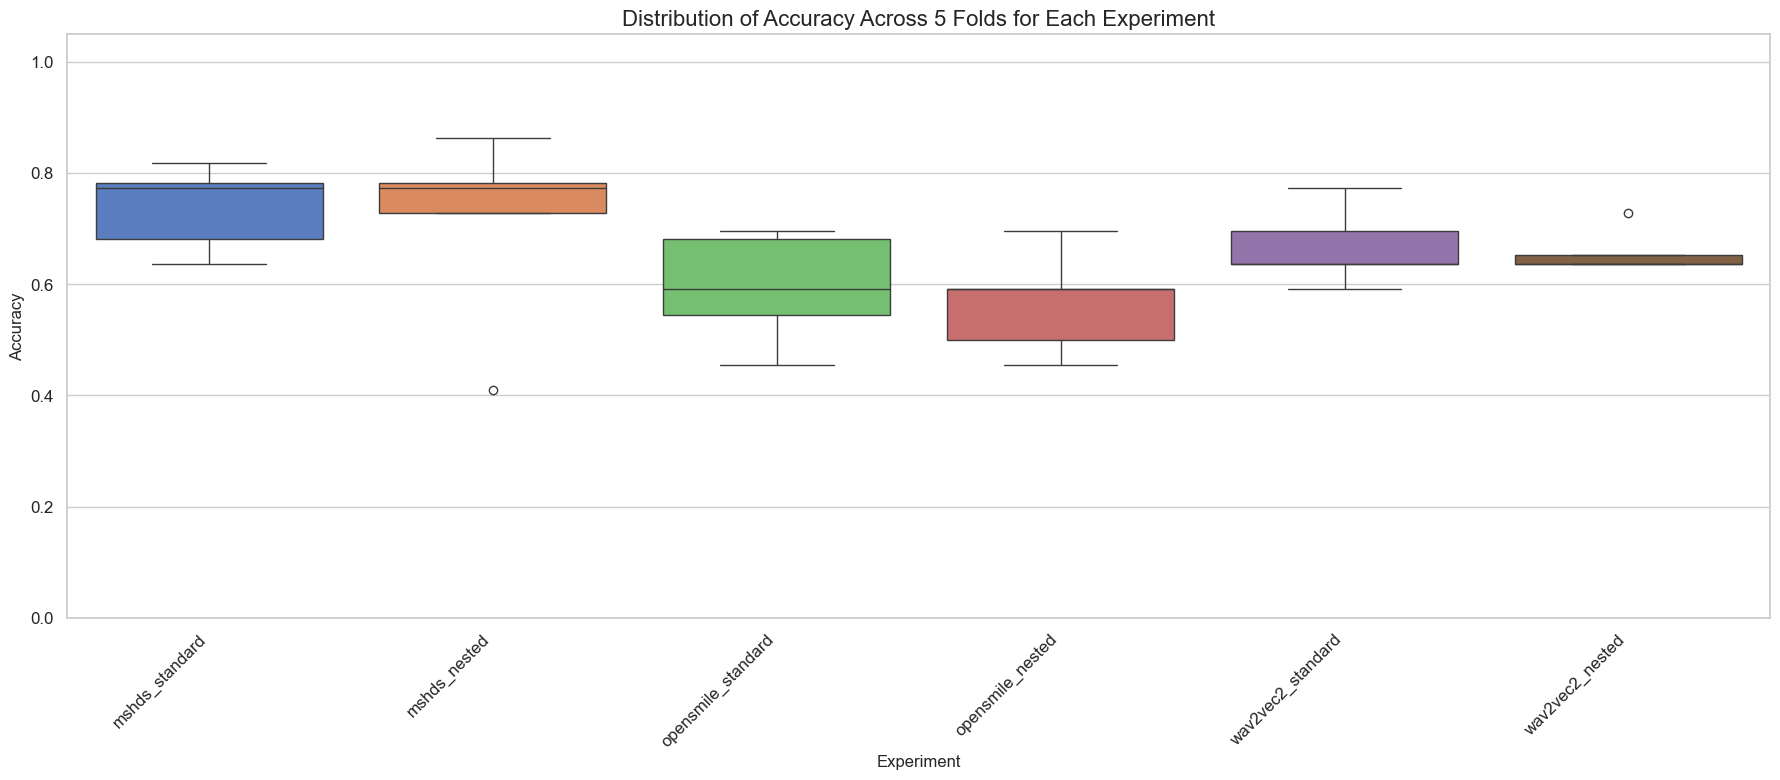

C:\Users\ayush\AppData\Local\Temp\ipykernel_22072\3327074775.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=long_form_df, x='experiment', y=metric, palette='muted')


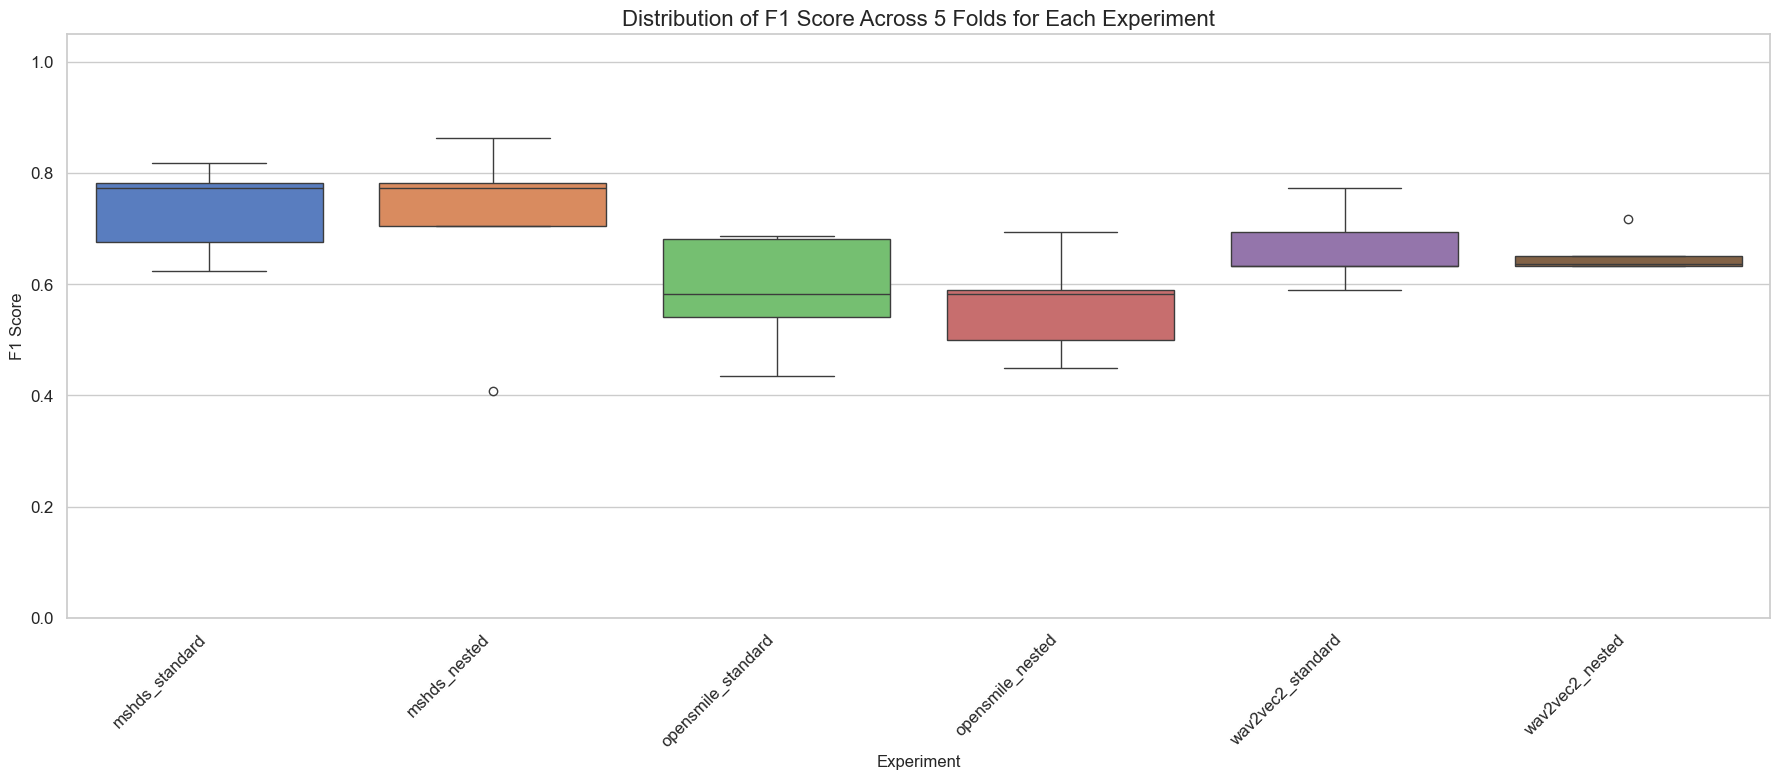

C:\Users\ayush\AppData\Local\Temp\ipykernel_22072\3327074775.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=long_form_df, x='experiment', y=metric, palette='muted')


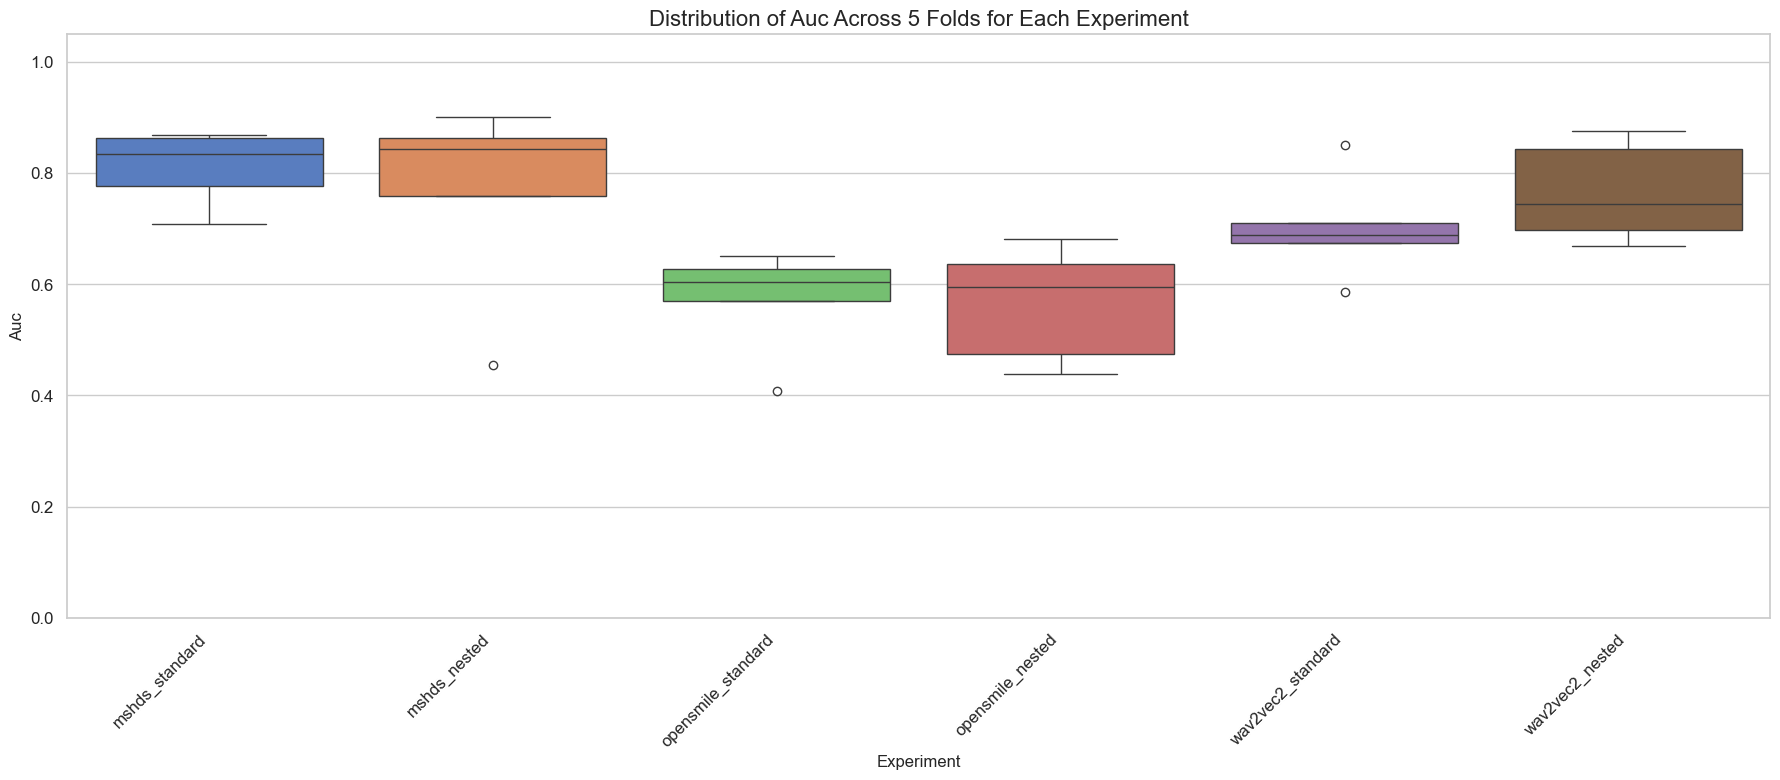

In [ ]:
# Visualize Distribution of Scores Across Folds

print("--- Generating Box Plots to Show Score Distribution Across Folds ---")

# Prepare a "long-form" DataFrame suitable for Seaborn.
# Combines the results from all experiments into one table.
all_fold_results = []
for experiment_name, data in all_results.items():
    # Make a copy to avoid modifying the original results
    df = data['results_df'].copy()
    df['experiment'] = experiment_name
    all_fold_results.append(df)

long_form_df = pd.concat(all_fold_results, ignore_index=True)

# List of metrics to visualize
metrics_to_plot = ['accuracy', 'f1_score', 'auc']

# Create a separate box plot for each metric
for metric in metrics_to_plot:
    plt.figure(figsize=(18, 8))
    
    # Create the box plot
    sns.boxplot(data=long_form_df, x='experiment', y=metric, palette='muted')
    
    # Add titles and labels to make the plot clear
    metric_name_formatted = metric.replace('_', ' ').title()
    plt.title(f'Distribution of {metric_name_formatted} Across 5 Folds for Each Experiment', fontsize=16)
    plt.xlabel('Experiment', fontsize=12)
    plt.ylabel(metric_name_formatted, fontsize=12)
    plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
    plt.ylim(0, 1.05) # Set a consistent y-axis scale
    plt.tight_layout()
    
    # Show the plot
    plt.show()

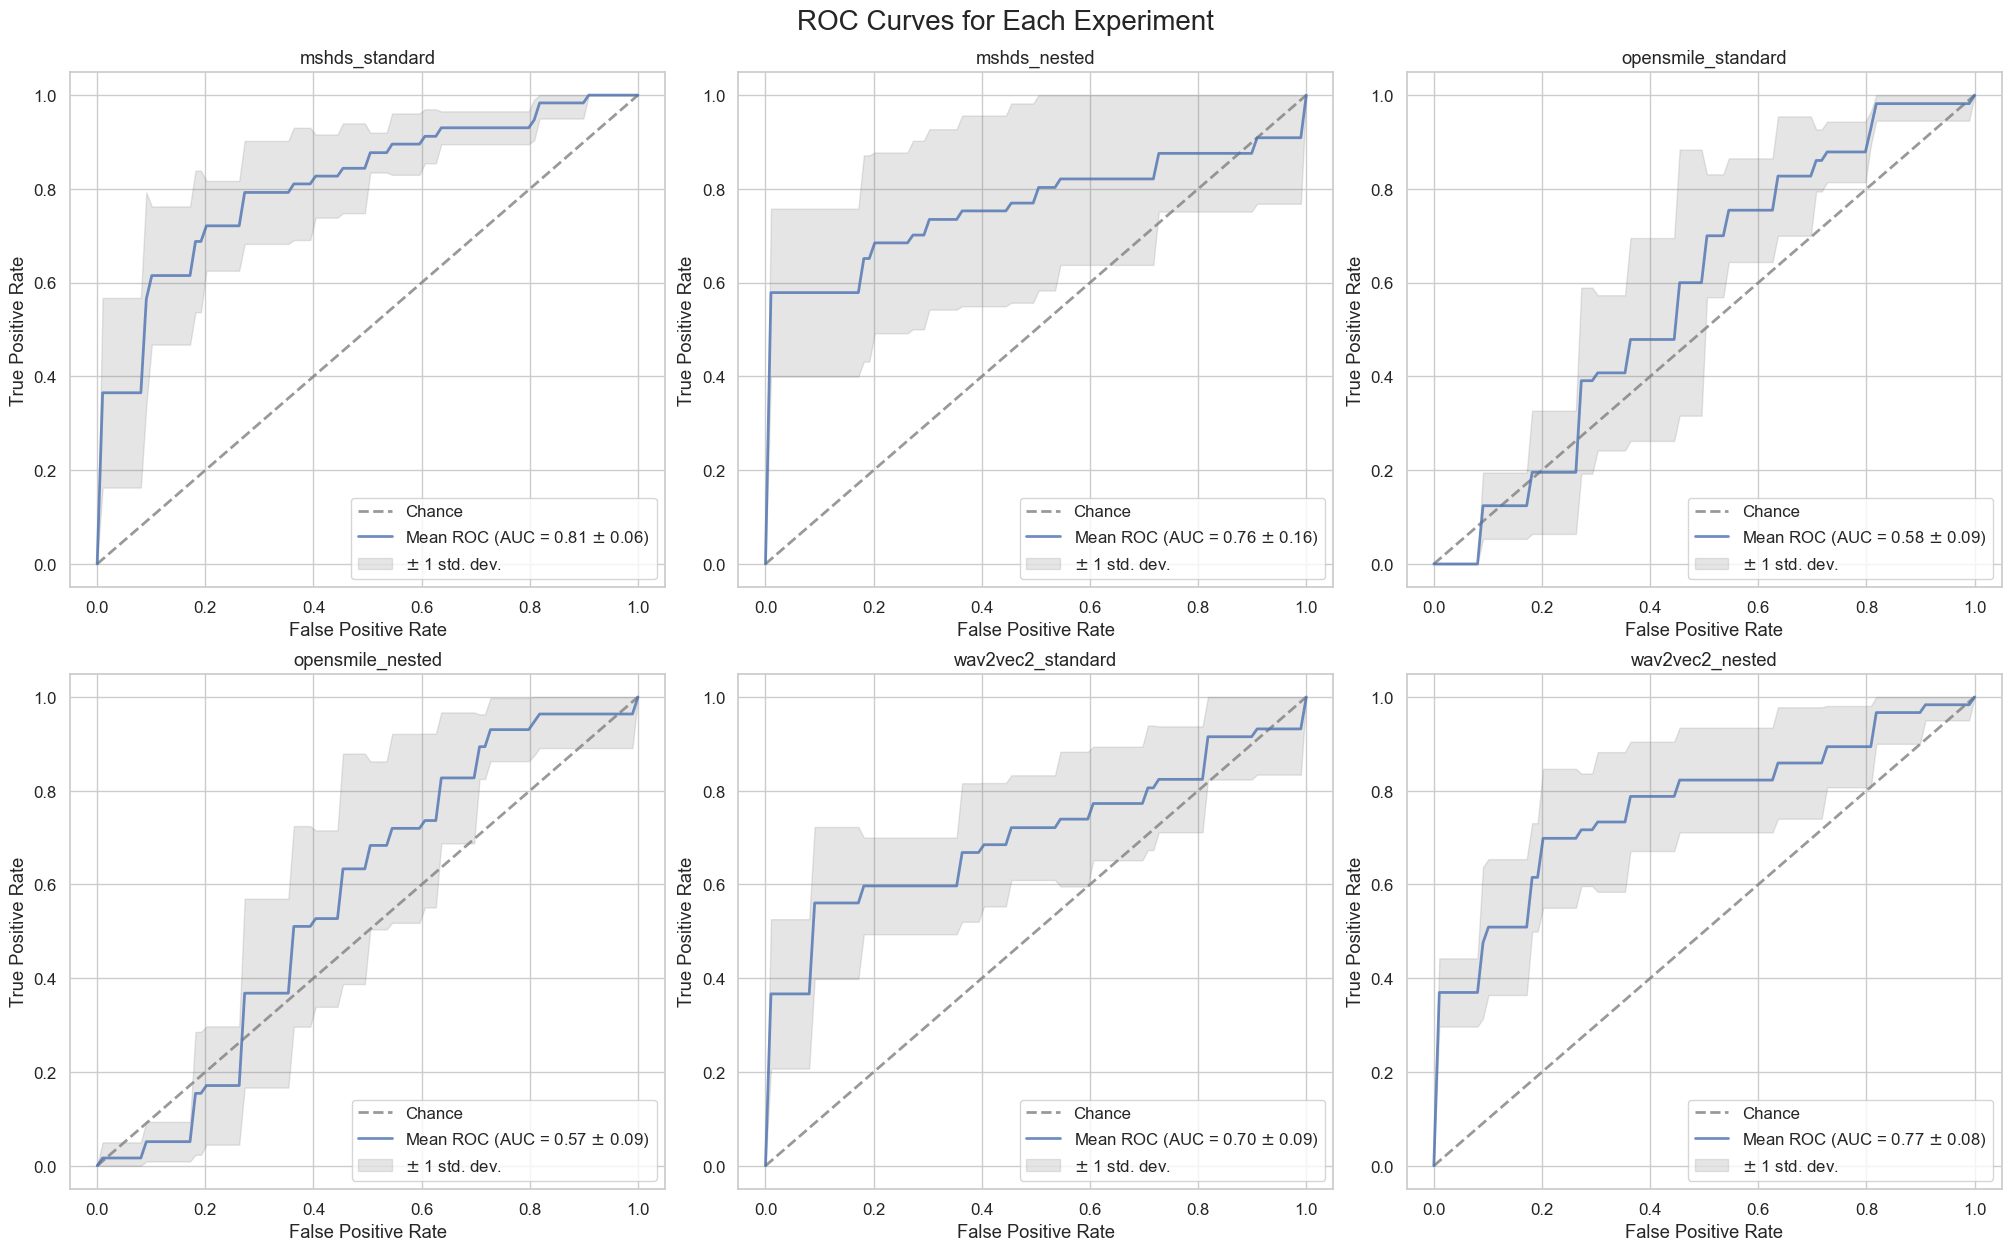

In [ ]:
# Visualize ROC Curves for Each Experiment

fig, axes = plt.subplots(2, 3, figsize=(20, 12), constrained_layout=True)
axes = axes.ravel() # Flatten the 2x3 grid

fig.suptitle('ROC Curves for Each Experiment', fontsize=20, y=1.03)

for i, (experiment_name, data) in enumerate(all_results.items()):
    ax = axes[i]
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    
    for fold_data in data['predictions']:
        fpr, tpr, _ = roc_curve(fold_data['y_true'], fold_data['y_prob'])
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey', label='Chance', alpha=.8)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})', lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title=f"{experiment_name}",
           xlabel="False Positive Rate",
           ylabel="True Positive Rate")
    ax.legend(loc="lower right")

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.show()

C:\Users\ayush\AppData\Local\Temp\ipykernel_22072\932785929.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')


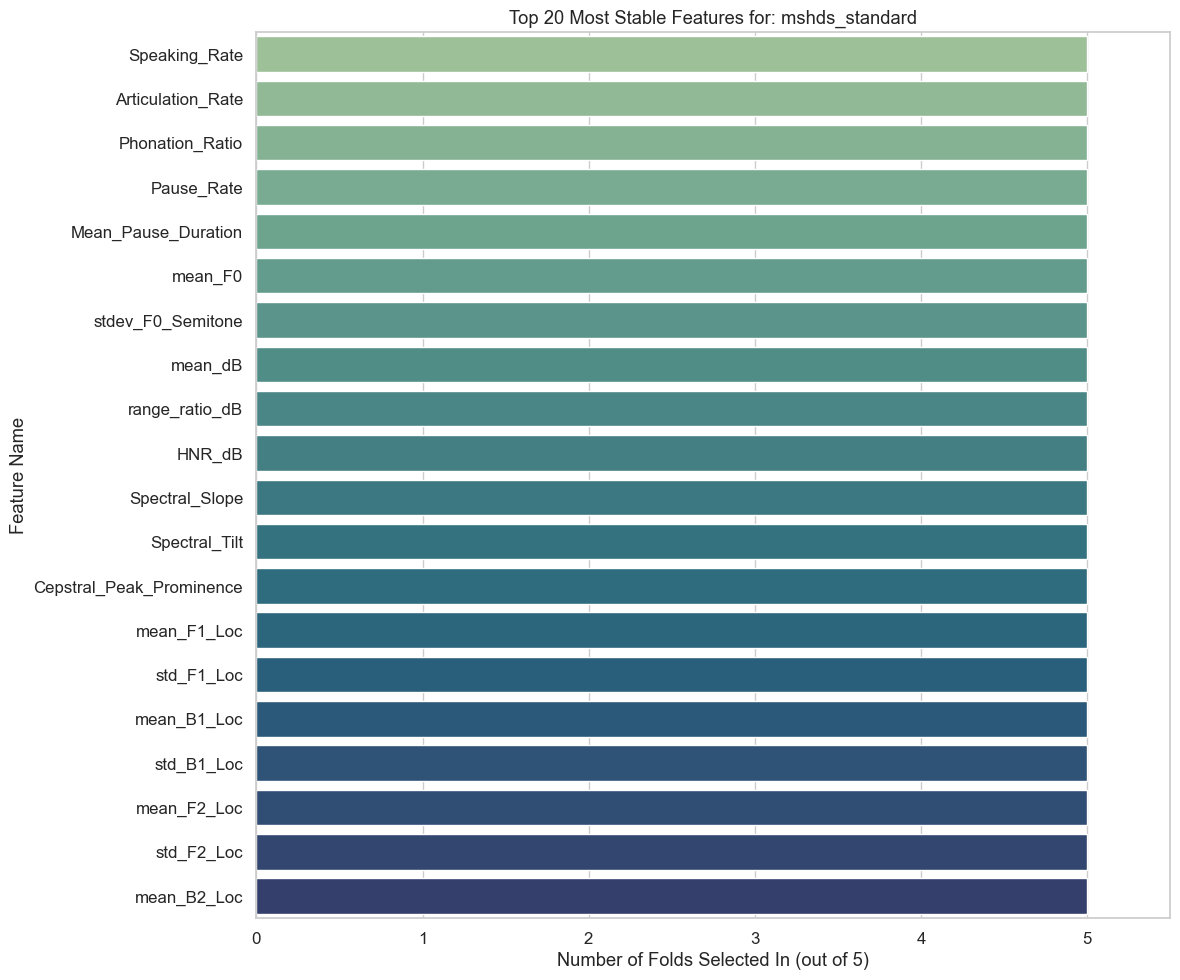

C:\Users\ayush\AppData\Local\Temp\ipykernel_22072\932785929.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')


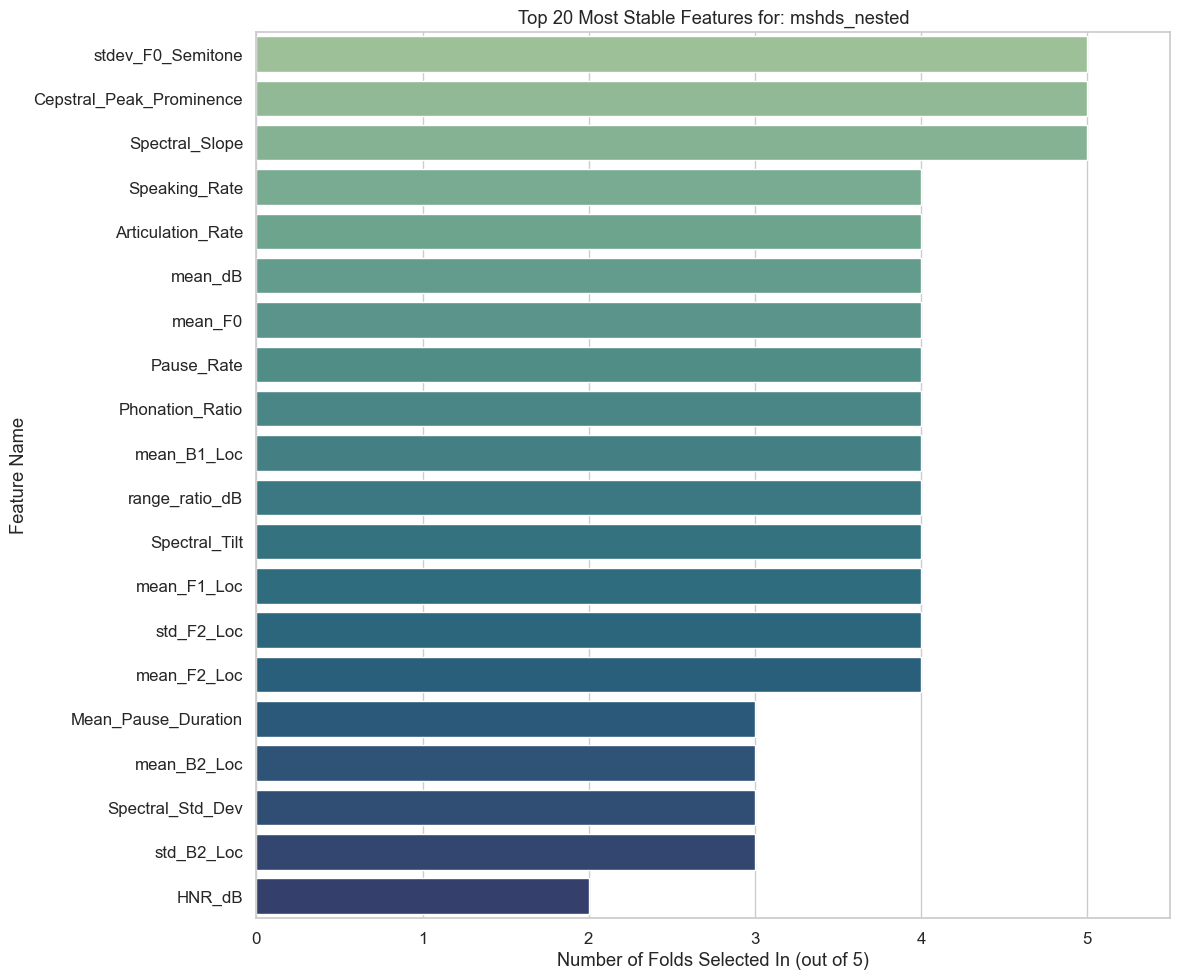

C:\Users\ayush\AppData\Local\Temp\ipykernel_22072\932785929.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')


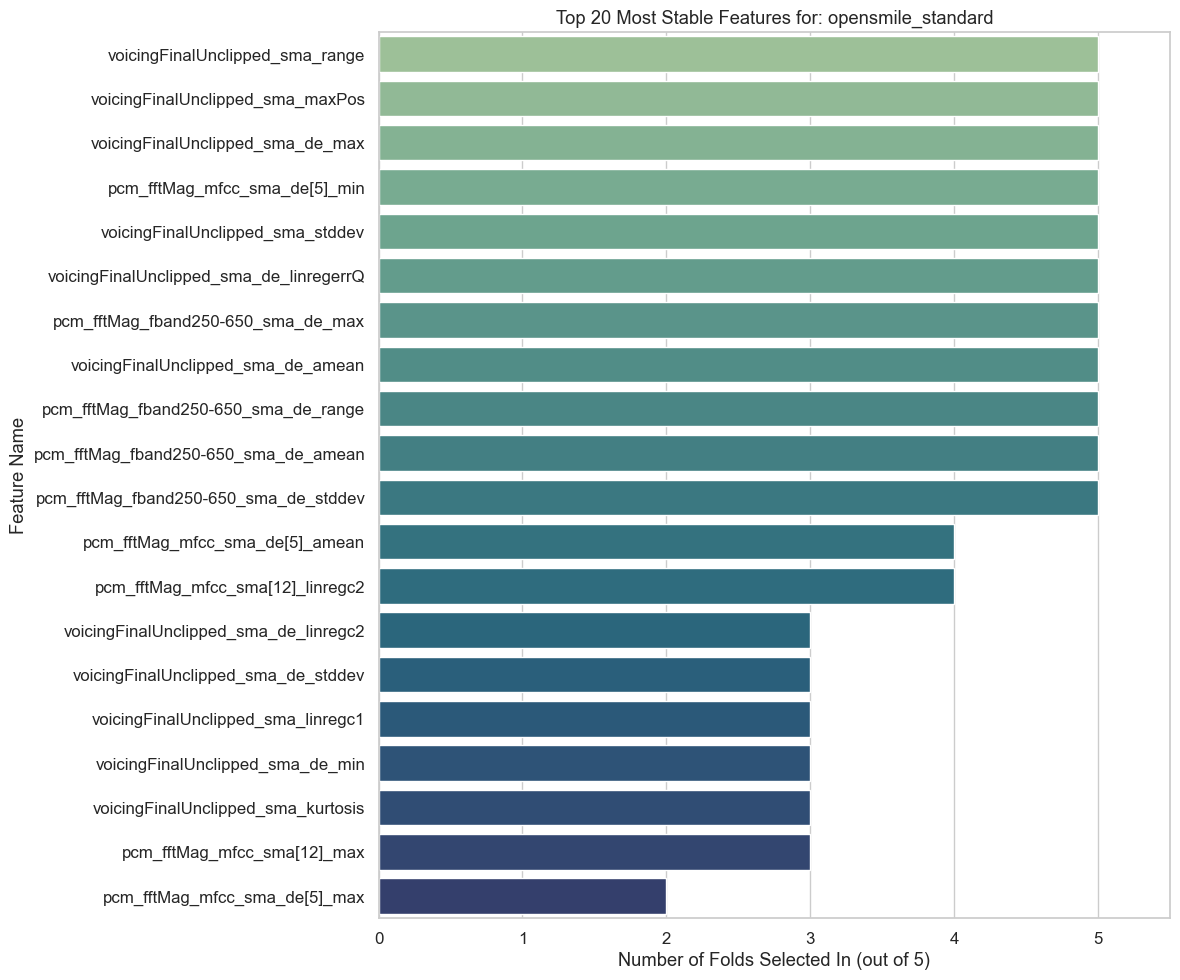

C:\Users\ayush\AppData\Local\Temp\ipykernel_22072\932785929.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')


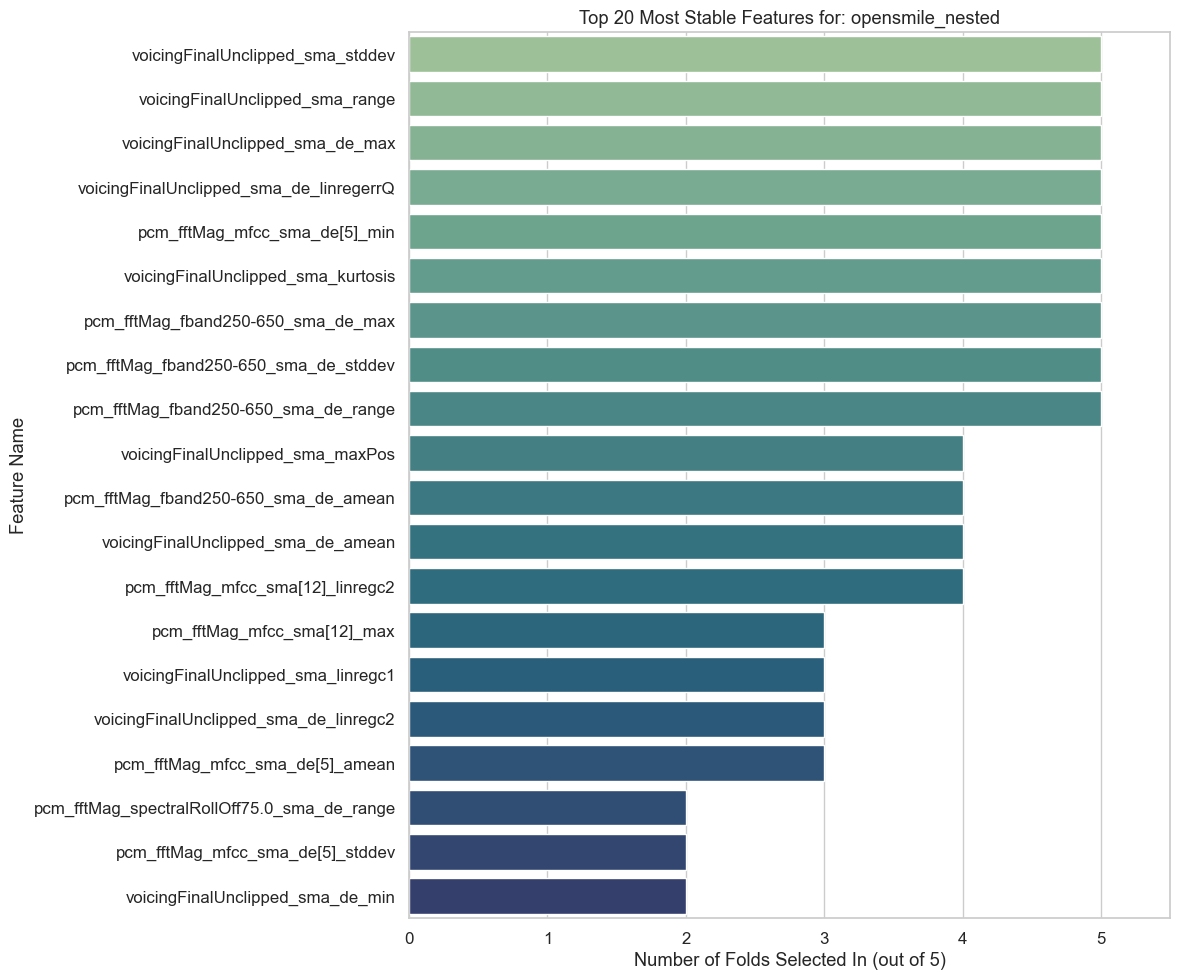

C:\Users\ayush\AppData\Local\Temp\ipykernel_22072\932785929.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')


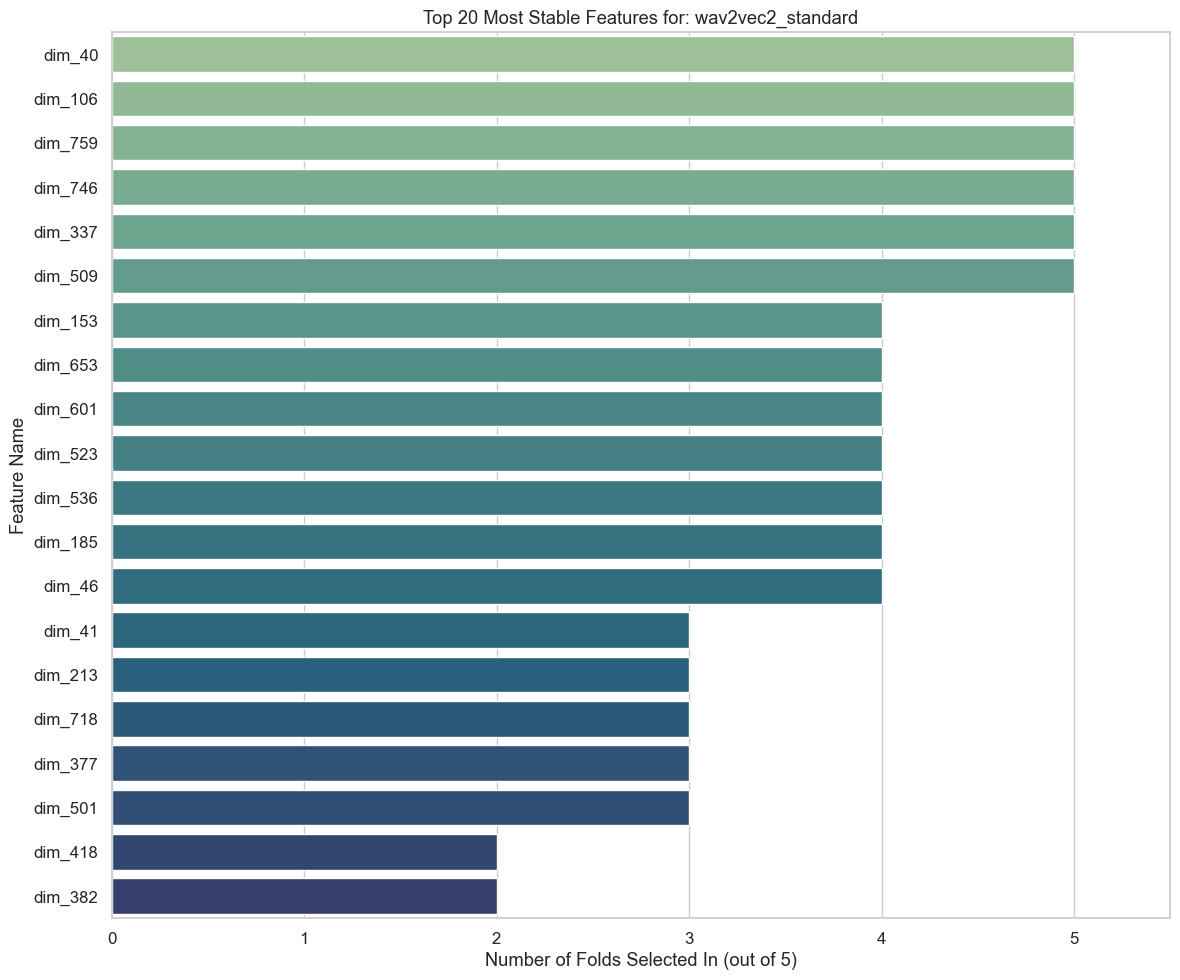

C:\Users\ayush\AppData\Local\Temp\ipykernel_22072\932785929.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')


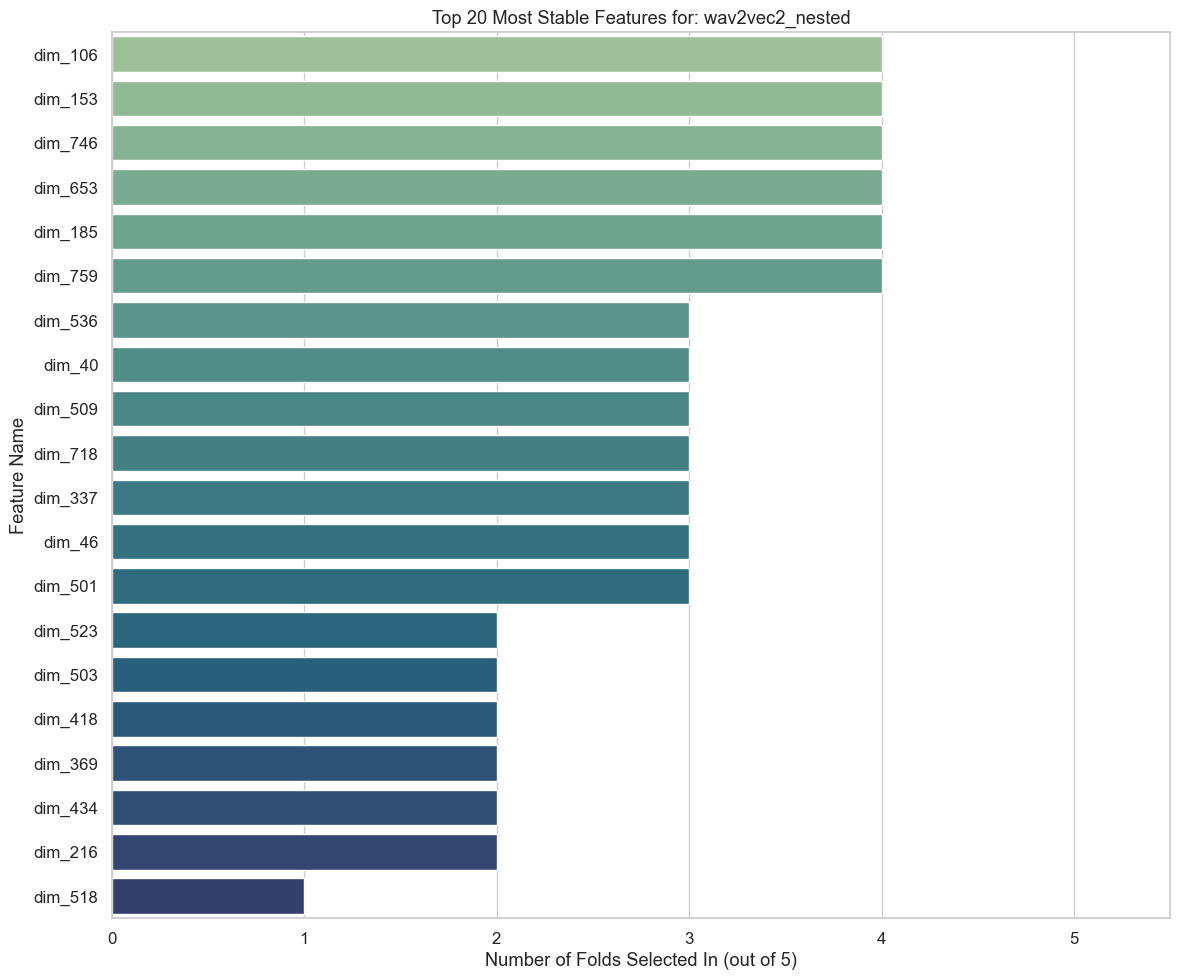

In [ ]:
# Analyze and Visualize Feature Stability

def analyze_and_plot_feature_stability(results_df, experiment_name, top_n=20):
    """Counts feature frequencies and plots the top N most stable features."""
    
    all_selected_features = list(itertools.chain.from_iterable(results_df['selected_features']))
    feature_counts = Counter(all_selected_features)
    
    if not feature_counts:
        print(f"No features were selected for experiment: {experiment_name}")
        return
        
    feature_freq_df = pd.DataFrame(feature_counts.items(), columns=['feature', 'count'])
    feature_freq_df = feature_freq_df.sort_values(by='count', ascending=False)
    
    plt.figure(figsize=(12, 10))
    sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')
    plt.title(f'Top {top_n} Most Stable Features for: {experiment_name}')
    plt.xlabel('Number of Folds Selected In (out of 5)')
    plt.ylabel('Feature Name')
    plt.xlim(0, 5.5)
    plt.tight_layout()
    plt.show()

# Run the stability analysis for each experiment
for experiment_name, data in all_results.items():
    analyze_and_plot_feature_stability(data['results_df'], experiment_name)